In [34]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as sk_data
from sklearn.cluster import KMeans

#import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# Clustering III: Hierarchical Clustering

Today we will look at a fairly different approach to clustering.

So far, we have been thinking of clustering as finding a __partition__ of our dataset.

That is, a set of nonoverlapping clusters, in which each data item is in one cluster.

However, in many cases, the notion of a strict partition is not as useful.

## How Many Clusters?

How many clusters would you say there are here?

In [35]:
X_rand, y_rand = sk_data.make_blobs(n_samples=[100, 100, 250, 70, 75, 80], centers = [[1, 2], [1.5, 1], [3, 2], [1.75, 3.25], [2, 4], [2.25, 3.25]], n_features = 2,
                          center_box = (-10.0, 10.0), cluster_std = [.2, .2, .3, .1, .15, .15], random_state = 0)
df_rand = pd.DataFrame(np.column_stack([X_rand[:, 0], X_rand[:, 1], y_rand]), columns = ['X', 'Y', 'label'])
df_rand = df_rand.astype({'label': 'int'})
df_rand['label2'] = [{0: 0, 1: 1, 2: 2, 3: 3, 4: 3, 5: 3}[x] for x in df_rand['label']]
df_rand['label3'] = [{0: 0, 1: 0, 2: 1, 3: 2, 4: 2, 5: 2}[x] for x in df_rand['label']]
# kmeans = KMeans(init = 'k-means++', n_clusters = 3, n_init = 100)
# df_rand['label'] = kmeans.fit_predict(df_rand[['X', 'Y']])

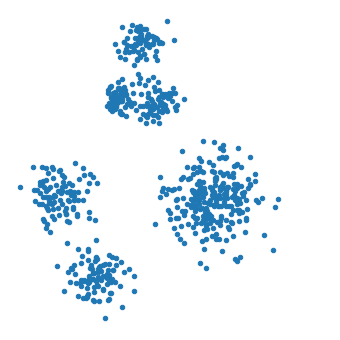

In [36]:
df_rand.plot('X', 'Y', kind = 'scatter', colormap='viridis', 
                   colorbar = False, figsize = (6, 6))
plt.axis('square')
plt.axis('off');

__Three clusters?__

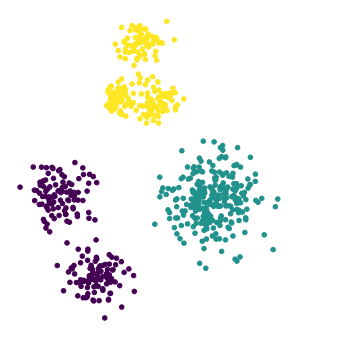

In [37]:
df_rand.plot('X', 'Y', kind = 'scatter', c = 'label3', colormap='viridis', 
                   colorbar = False, figsize = (6, 6))
plt.axis('square')
plt.axis('off');

__Four clusters?__

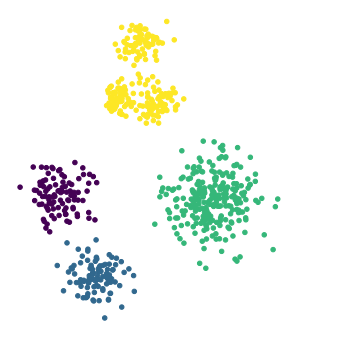

In [38]:
df_rand.plot('X', 'Y', kind = 'scatter', c = 'label2', colormap='viridis', 
                   colorbar = False, figsize = (6, 6))
plt.axis('square')
plt.axis('off');

__Six clusters?__

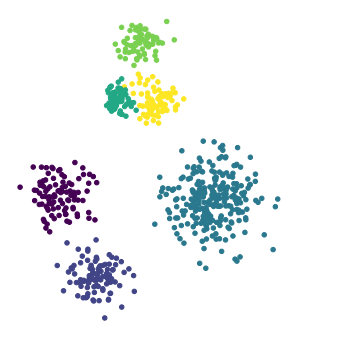

In [39]:
df_rand.plot('X', 'Y', kind = 'scatter', c = 'label', colormap='viridis', 
                   colorbar = False, figsize = (6, 6))
plt.axis('square')
plt.axis('off');

This dataset shows clustering on __multiple scales.__

To fully capture the structure in this dataset, two things are needed:
1. Capturing the differing clusters depending on the scale
2. Capturing the containment relations -- which clusters lie within other clusters

These observations motivate the notion of __hierarchical__ clustering.

In hierarchical clustering, we move away from the __partition__ notion of $k$-means, 

and instead capture a more complex arrangement that includes containment of one cluster within another.

## Hierarchical Clustering

A hierarchical clustering produces a set of __nested__ clusters organized into a tree.

A hierarchical clustering is visualized using a __dendrogram__ 

* A tree-like diagram that records the containment relations among clusters.

<center>

<img src="./figs/L08-dendrogram.png" width="600px">

</center>

### Strengths of Hierarchical Clustering

Hierarchical clustering has a number of advantages:

First, a hierarchical clustering encodes many __different__ clusterings.  That is, it does not itself decide on the correct number of clusters.  

A clustering is obtained by "cutting" the dendrogram at some level.

This means that you can make this crucial decision yourself, by inspecting the dendrogram.  

Put another way, you can obtain any desired number of clusters.

<center>

<img src="./figs/L08-dendrogram-cut.png" width="600px">

</center>

The second advantage is that the dendrogram may itself correspond to a meaningful structure, for example, a taxonomy.

<center>

<img src="figs/L08-animal-taxonomy.jpg" width="600px">

</center>

The third advantage is that many hierarchical clustering methods can be performed using either similarity (proximity) or dissimilarity (distance) metrics.

This can be very helpful! 

(Note that techniques like $k$-means cannot be used with unmodified similarity metrics.)

### Compared to $k$-means

Another aspect of hierachical clustering is that it can handle certain cases better than $k$-means.

Because of the nature of the $k$-means algorithm, $k$-means tends to produce:
* Roughly spherical clusters
* Clusters of approximately equal size
* Non-overlapping clusters

In many real-world situations, clusters may not be round, they may be of unequal size, and they may overlap.

Hence we would like clustering algorithms that can work in those cases also.

## Hierarchical Clustering Algorithms

There are two main approaches to hierarchical clustering: "bottom-up" and "top-down."

__Agglomerative__ Clustering ("bottom-up"):

* Start by defining each point as its own cluster
* At each successive step, merge the two clusters that are closest to each other
* Repeat until only one cluster is left.

__Divisive__ Clustering ("top-down"):
    
* Start with one, all-inclusive cluster
* At each step, find the cluster split that creates the largest distance between resulting clusters
* Repeat until each point is in its own cluster.

Agglomerative techniques are by far the more common.

The key to both of these methods is defining __the distance between two clusters.__

Different definitions for the inter-cluster distance yield different clusterings.

To illustrate the impact of the choice of cluster distances, we'll focus on agglomerative clustering.

### Defining Cluster Proximity

Given two clusters, how do we define the _distance_ between them?

Here are three natural ways to do it:
   * __Single-Linkage:__ the distance between two clusters is the distance between the closest two points that are in different clusters.
   
$$ D_\text{single}(i,j) = \min_{x, y}\{d(x, y) \,|\, x \in C_i, y \in C_j\}$$

* __Complete-Linkage:__ the distance between two clusters is the distance between the farthest two points that are in different clusters.

$$ D_\text{complete}(i,j) = \max_{x, y}\{d(x, y) \,|\, x \in C_i, y \in C_j\}$$

* __Group Average:__ the distance between two clusters is the average distance between all pairs of points from different clusters.

$$ D_\text{average}(i,j) = \frac{1}{|C_i|\cdot|C_j|}\sum_{x \in C_i,\, y \in C_j}d(x, y)$$

<center>

<img src="./figs/L08-hierarchical-criteria.png" width="600px">

</center>

$$\text{Single-Linkage}\;\;\;\;\;\;\text{Complete-Linkage}\;\;\;\;\;\;\text{Group Average}$$

Notice that it is easy to express the definitions above in terms of similarity instead of distance.

Here is a set of 6 points that we will cluster to show differences between distance metrics.

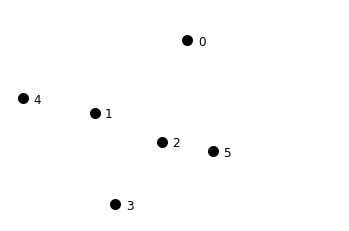

In [40]:
pt_x = [0.4, 0.22, 0.35, 0.26, 0.08, 0.45]
pt_y = [0.53, 0.38, 0.32, 0.19, 0.41, 0.30]
plt.plot(pt_x, pt_y, 'o', markersize = 10, color = 'k')
plt.ylim([.15, .60])
plt.xlim([0.05, 0.70])
for i in range(6):
    plt.annotate(f'{i}', (pt_x[i]+0.02, pt_y[i]-0.01), fontsize = 12)
plt.axis('off')
plt.savefig('figs/L08-basic-pointset.png');

In [41]:
X = np.array([pt_x, pt_y]).T
from scipy.spatial import distance_matrix
labels = ['p0', 'p1', 'p2', 'p3', 'p4', 'p5']
D = pd.DataFrame(distance_matrix(X, X), index = labels, columns = labels)
#with pd.option_context('display.float_format', '{:,.2f}'.format):
#    print(D)
D.style.format('{:.2f}')

,p0,p1,p2,p3,p4,p5
p0,0.00,0.23,0.22,0.37,0.34,0.24
p1,0.23,0.00,0.14,0.19,0.14,0.24
p2,0.22,0.14,0.00,0.16,0.28,0.10
p3,0.37,0.19,0.16,0.00,0.28,0.22
p4,0.34,0.14,0.28,0.28,0.00,0.39
p5,0.24,0.24,0.10,0.22,0.39,0.00


### Single-Link Clustering

<img src="figs/L08-singlelink-pointset.png" width="100%">

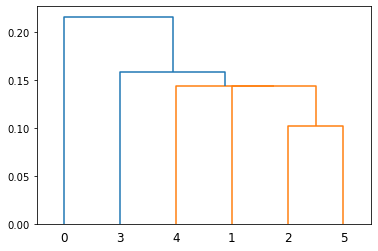

In [42]:
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
Z = hierarchy.linkage(X, method='single')
hierarchy.dendrogram(Z);

__Advantages__:

* Single-link clustering can handle non-elliptical shapes.

In fact it can produce long, elongated clusters:

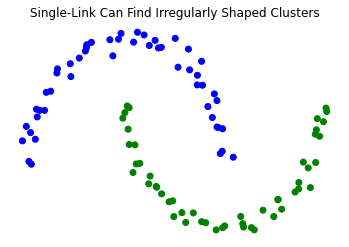

In [43]:
X_moon_05, y_moon_05 = sk_data.make_moons(random_state = 0, noise = 0.05)
Z = hierarchy.linkage(X_moon_05, method='single')
labels = hierarchy.fcluster(Z, 2, criterion = 'maxclust')
plt.scatter(X_moon_05[:,0], X_moon_05[:,1], c = [['b','g'][i-1] for i in labels])
plt.title('Single-Link Can Find Irregularly Shaped Clusters')
plt.axis('off');

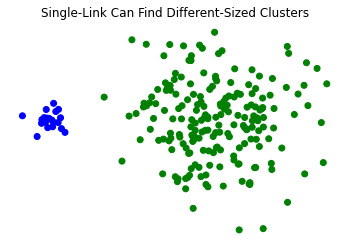

In [44]:
X_rand_lo, y_rand_lo = sk_data.make_blobs(n_samples=[20, 200], centers = [[1, 1], [3, 1]], n_features = 2,
                          center_box = (-10.0, 10.0), cluster_std = [.1, .5], random_state = 0)
Z = hierarchy.linkage(X_rand_lo, method='single')
labels = hierarchy.fcluster(Z, 2, criterion = 'maxclust')
plt.scatter(X_rand_lo[:,0], X_rand_lo[:,1], c = [['b','g'][i-1] for i in labels])
plt.title('Single-Link Can Find Different-Sized Clusters')
plt.axis('off');

__Disadvantages:__ 

* Single-link clustering can be sensitive to noise and outliers.

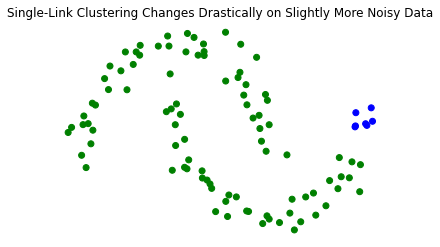

In [45]:
X_moon_10, y_moon_10 = sk_data.make_moons(random_state = 0, noise = 0.1)
Z = hierarchy.linkage(X_moon_10, method='single')
labels = hierarchy.fcluster(Z, 2, criterion = 'maxclust')
plt.scatter(X_moon_10[:,0], X_moon_10[:,1], c = [['b','g'][i-1] for i in labels])
plt.title('Single-Link Clustering Changes Drastically on Slightly More Noisy Data')
plt.axis('off');
#hierarchy.dendrogram(Z);

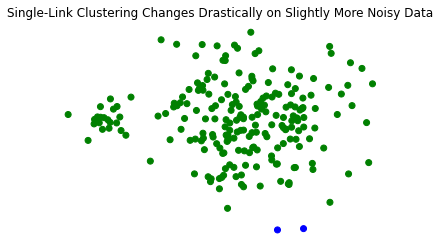

In [46]:
X_rand_hi, y_rand_hi = sk_data.make_blobs(n_samples=[20, 200], centers = [[1, 1], [3, 1]], n_features = 2,
                          center_box = (-10.0, 10.0), cluster_std = [.15, .6], random_state = 0)
Z = hierarchy.linkage(X_rand_hi, method='single')
labels = hierarchy.fcluster(Z, 2, criterion = 'maxclust')
plt.title('Single-Link Clustering Changes Drastically on Slightly More Noisy Data')
plt.scatter(X_rand_hi[:,0], X_rand_hi[:,1], c = [['b','g'][i-1] for i in labels])
plt.axis('off');

### Complete-Link Clustering

<img src="figs/L08-completelink-pointset.png" width="100%">

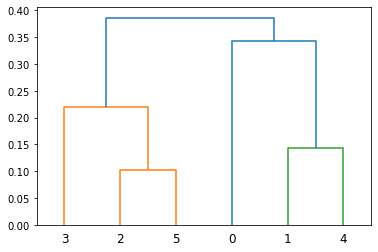

In [47]:
Z = hierarchy.linkage(X, method='complete')
hierarchy.dendrogram(Z);

__Advantages__:

* Produces more-balanced clusters -- more-equal diameters

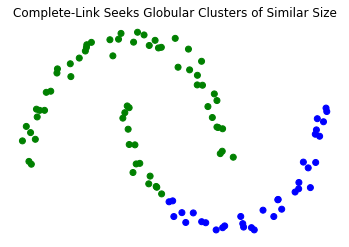

In [48]:
X_moon_05, y_moon_05 = sk_data.make_moons(random_state = 0, noise = 0.05)
Z = hierarchy.linkage(X_moon_05, method='complete')
labels = hierarchy.fcluster(Z, 2, criterion = 'maxclust')
plt.scatter(X_moon_05[:,0], X_moon_05[:,1], c = [['b','g'][i-1] for i in labels])
plt.title('Complete-Link Seeks Globular Clusters of Similar Size')
plt.axis('off');

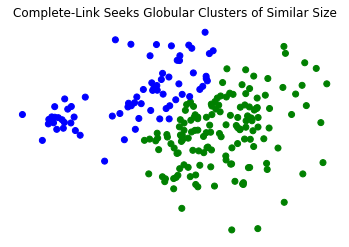

In [49]:
Z = hierarchy.linkage(X_rand_hi, method='complete')
labels = hierarchy.fcluster(Z, 2, criterion = 'maxclust')
plt.scatter(X_rand_hi[:,0], X_rand_hi[:,1], c = [['b','g'][i-1] for i in labels])
plt.title('Complete-Link Seeks Globular Clusters of Similar Size')
plt.axis('off');

Less susceptible to noise:

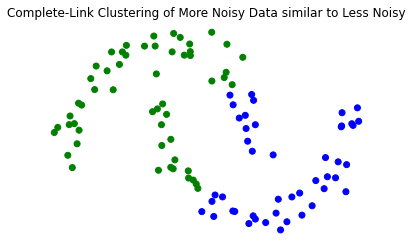

In [50]:
Z = hierarchy.linkage(X_moon_10, method='complete')
labels = hierarchy.fcluster(Z, 2, criterion = 'maxclust')
plt.scatter(X_moon_10[:,0], X_moon_10[:,1], c = [['b','g'][i-1] for i in labels])
plt.title('Complete-Link Clustering of More Noisy Data similar to Less Noisy')
plt.axis('off');

### Average-Link Clustering

<img src="figs/L08-averagelink-pointset.png" width="100%">

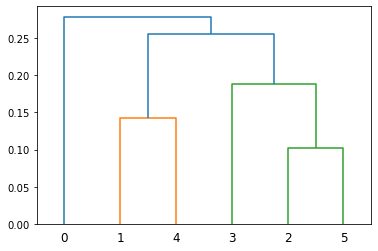

In [51]:
Z = hierarchy.linkage(X, method='average')
hierarchy.dendrogram(Z);

Average-Link clustering is in some sense a compromise between Single-link and Complete-link clustering.

__Strengths:__
    
* Less susceptible to noise and outliers

__Limitations:__
    
* Biased toward elliptical clusters

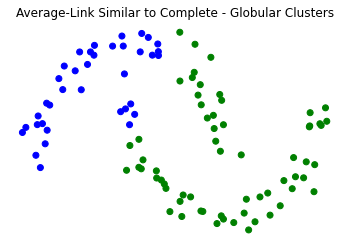

In [52]:
Z = hierarchy.linkage(X_moon_10, method='average')
labels = hierarchy.fcluster(Z, 2, criterion = 'maxclust')
plt.scatter(X_moon_10[:,0], X_moon_10[:,1], c = [['b','g'][i-1] for i in labels])
plt.title('Average-Link Similar to Complete - Globular Clusters')
plt.axis('off');

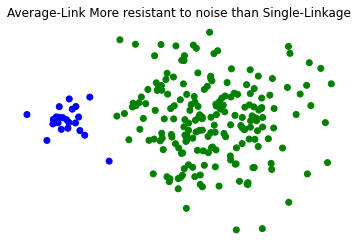

In [57]:
Z = hierarchy.linkage(X_rand_hi, method='average')
labels = hierarchy.fcluster(Z, 2, criterion = 'maxclust')
plt.scatter(X_rand_hi[:,0], X_rand_hi[:,1], c = [['b','g'][i-1] for i in labels])
plt.title('Average-Link More resistant to noise than Single-Linkage')
plt.axis('off');

### All Three Compared

<div style = "float: left; width: 33.33%; text-align: center;">
    <img src="figs/L08-singlelink-pointset.png" style="width:100%">
    Single Link
</div>
<div style = "float: left; width: 33.33%; text-align: center;">
    <img src="figs/L08-completelink-pointset.png"  style="width:100%">
    Complete Link
</div>
<div style = "float: left; width: 33.33%; text-align: center;">
    <img src="figs/L08-averagelink-pointset.png" style="width:100%">
    Average Link
</div>

## Ward's Distance

Finally, we consider one more cluster distance.

Ward's distance asks "what if".

That is, "What if we combined these two clusters -- how would clustering improve?"

To define "how would clustering improve?" we appeal to the $k$-means criterion.

So:

__Ward's Distance__ between clusters $C_i$ and $C_j$ is the difference between the total within cluster sum of squares for the two clusters separately, __compared to__ the within cluster sum of squares resulting from merging the two clusters into a new cluster $C_{i+j}$:

$$D_\text{Ward} = \sum_{x \in C_i} (x - r_i)^2 + \sum_{x \in C_j} (x - r_j)^2  - \sum_{x \in C_{i+j}} (x - r_{i+j})^2 $$

where $r_i, r_j, r_{i+j}$ are the corresponding cluster centroids.

In a sense, this cluster distance results in a hierarchical analog of $k$-means.

As a result, it behaves similarly to $k$-means:
    
* Less susceptible to noise and outliers
* Biased toward elliptical clusters

Hence it tends to behavior more like group-average hierarchical clustering.

## Hierarchical Clustering In Practice

Now we'll look at doing hierarchical clustering in practice, using python.

We'll use the same synthetic data as we did in the k-means case -- ie.,
three "blobs" living in 30 dimensions.

In [54]:
X, y = sk_data.make_blobs(n_samples=100, centers=3, n_features=30,
                          center_box=(-10.0, 10.0),random_state=0)

As a reminder of the raw data here is the visualization: first the raw data, then an embedding into 2-D (using MDS).

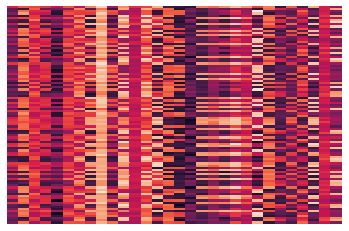

In [32]:
sns.heatmap(X, xticklabels=False, yticklabels=False, linewidths=0,cbar=False);

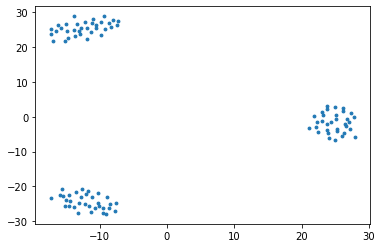

In [62]:
import sklearn.manifold
import sklearn.metrics as metrics
euclidean_dists = metrics.euclidean_distances(X)
mds = sklearn.manifold.MDS(n_components = 2, max_iter = 3000, eps = 1e-9, random_state = 0,
                   dissimilarity = "precomputed", n_jobs = 1)
fit = mds.fit(euclidean_dists)
pos = fit.embedding_
plt.scatter(pos[:, 0], pos[:, 1], s = 8);

Hierarchical clustering is available in __sklearn__, but there is a much more fully developed set of tools in the __scipy__ package and that is the one to use.

In [67]:
import scipy.cluster
import scipy.cluster.hierarchy as hierarchy
import scipy.spatial.distance
# linkages = ['single','complete','average','weighted','ward']
Z = hierarchy.linkage(X, method = 'single')

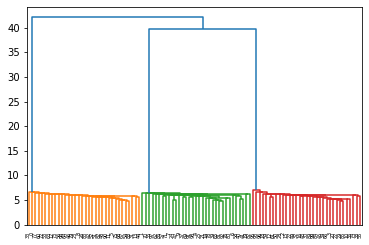

In [68]:
R = hierarchy.dendrogram(Z)

## Hierarchical Clustering Real Data

Once again we'll use the "20 Newsgroup" data provided as example data in sklearn.

(http://scikit-learn.org/stable/datasets/twenty_newsgroups.html).

In [69]:
from sklearn.datasets import fetch_20newsgroups
categories = ['comp.os.ms-windows.misc', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset = 'train', categories = categories)

In [70]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english', min_df = 4, max_df = 0.8)
data = vectorizer.fit_transform(news_data.data).todense()
data.shape

(1781, 9409)

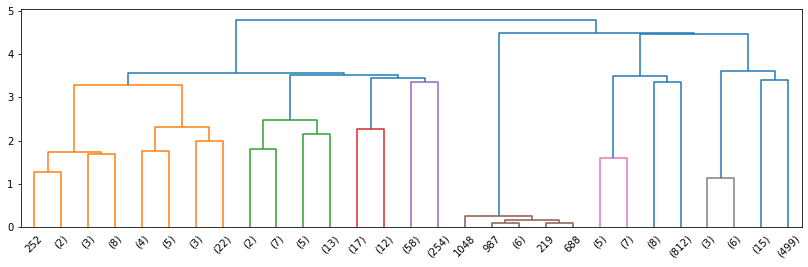

In [71]:
# metrics can be ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, 
# ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, 
# ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, 
# ‘sqeuclidean’, ‘yule’.
Z_20ng = hierarchy.linkage(data, method = 'ward', metric = 'euclidean')
plt.figure(figsize=(14,4))
R_20ng = hierarchy.dendrogram(Z_20ng, p=4, truncate_mode = 'level', show_leaf_counts=True)

### Selecting the Number of Clusters

In [73]:
clusters = hierarchy.fcluster(Z_20ng, 3, criterion = 'maxclust')
print(clusters.shape)
clusters

(1781,)


array([3, 3, 3, ..., 1, 3, 1], dtype=int32)

Text(0, 0.5, 'Silhouette Score')

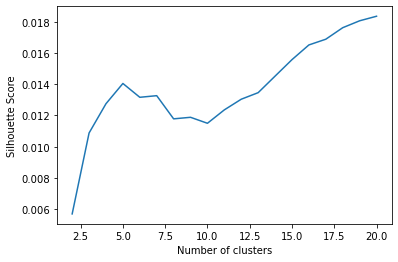

In [74]:
max_clusters = 20
s = np.zeros(max_clusters+1)
for k in range(2, max_clusters+1):
    clusters = hierarchy.fcluster(Z_20ng, k, criterion = 'maxclust')
    s[k] = metrics.silhouette_score(data, clusters, metric = 'euclidean')
plt.plot(range(2, len(s)), s[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score');